In [41]:
#IMPORTING ALL THE NECESSARY PACKAGES.
import matplotlib.pyplot as plt                #Importing matplotlib to plot and analyse data.
import pandas as pd
import plotly.express as px                                                  
from prophet import Prophet                  #Importing prophet (prediction and forecasting library.)
import sqlite3
from sqlite3 import Error
import yfinance as yf

In [18]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)

    return conn

def get_stock_prices(conn, symbol):

    sql = ''' SELECT Date, Open, High, Low, Close, Volume FROM stocks WHERE Name = ? '''
    cur = conn.cursor()
    cur.execute(sql, (symbol,))
    rows = cur.fetchall()
    df = pd.DataFrame(rows)
    col_map = {df.columns[0]: 'Date', df.columns[1]: 'Open', df.columns[2]: 'High', df.columns[3]: 'Low', df.columns[4]: 'Close', df.columns[5]: 'Volume'}
    df.rename(columns=col_map, inplace=True)
    df.set_index('Date', inplace=True)
    return df


In [42]:
conn = create_connection('stocks.db')
df = get_stock_prices(conn, 'OIL')
#df = yf.download('OIL', auto_adjust=True)
df = df.reset_index()
df[['ds','y']] = df[['Date','Close']]
df

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- OIL: No data found for this date range, symbol may be delisted


,Date,Open,High,Low,Close,Adj Close,Volume,ds,y


In [31]:
fig = px.line(df, x='Date', y='Close')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [32]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

In [33]:
# Python
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-21,0,2020-06-06,77
1,lockdown_2,2020-07-09,0,2020-10-27,110
2,lockdown_3,2021-02-13,0,2021-02-17,4
3,lockdown_4,2021-05-28,0,2021-06-10,13


In [34]:
m = Prophet(holidays=lockdowns)
m.add_country_holidays(country_name='US')
m.fit(df)


08:30:56 - cmdstanpy - INFO - Chain [1] start processing
08:31:21 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
future = m.make_future_dataframe(periods=90)
future.tail()

,ds
3032,2022-12-11
3033,2022-12-12
3034,2022-12-13
3035,2022-12-14
3036,2022-12-15


In [36]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3032,2022-12-11,3.840441,3.156398,4.541101
3033,2022-12-12,3.347321,2.611370,4.035994
3034,2022-12-13,3.333606,2.648653,4.063776
3035,2022-12-14,3.344995,2.662443,4.046810
3036,2022-12-15,3.327898,2.613591,4.033354


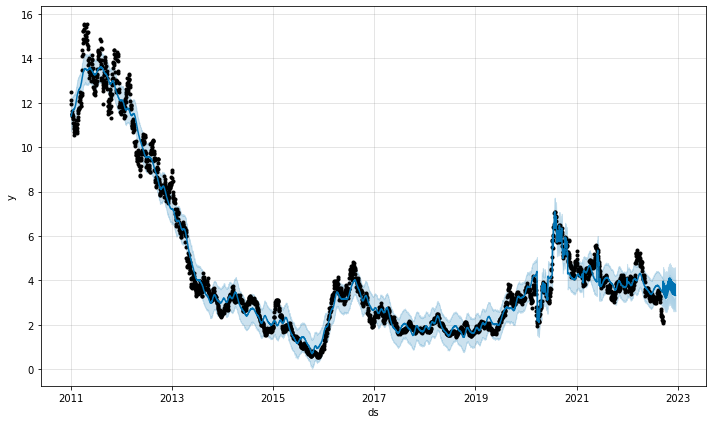

In [37]:
fig1 = m.plot(forecast)

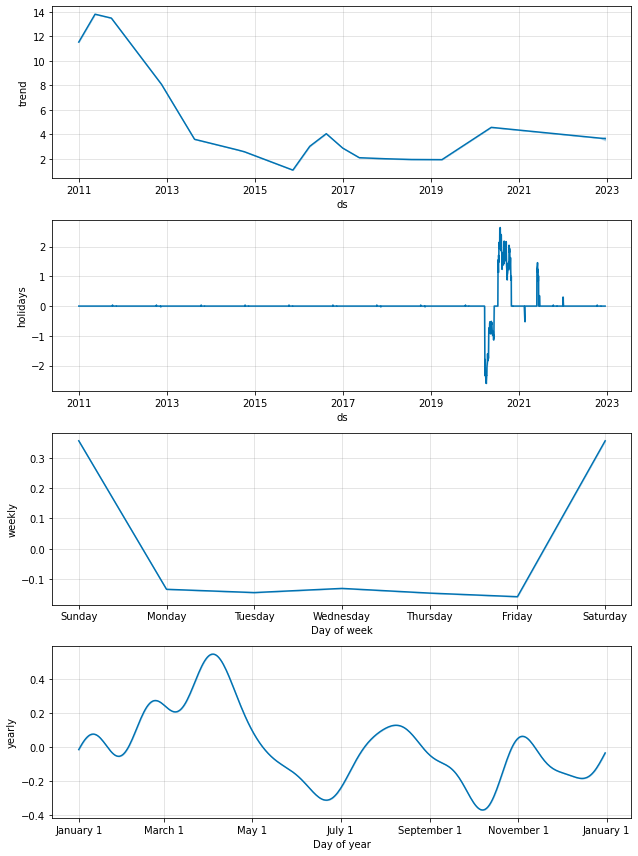

In [38]:
fig2 = m.plot_components(forecast)

In [39]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast, uncertainty=True, plot_cap=False, trend=True, changepoints=True)

In [40]:
plot_components_plotly(m, forecast)